In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import *
from scipy.optimize import curve_fit
from scipy import integrate

filepath="D:\\Downloads\\300nm_optimum_data_angfreq.csv"

In [37]:
c=299792458

def get_phase(omega,Eomega, lambda0):
    #retrieves phase and subtracts the arbitrary phase at omega0
    om0 = 2*np.pi*c/lambda0 #central frequency
    om0_idx = np.argmin(np.abs(omega-om0))
 
    domega = omega[2] - omega[1]
    tau = np.pi/domega
    phase_raw = np.angle(Eomega)
    phase = np.unwrap(phase_raw - omega*tau)
    phase=phase*(-1)#optics convention
    phase -= phase[om0_idx]#subtract arbitrary phase offset
    return phase


In [38]:
def moment(x,y,n): 
    """
    returns an integral of the nth moment of intensity over frequency
    """
    integrand = np.array([]) #array of overlaps of the intensity with itself with a freq shift omega_shift
    for i in range(len(x)):
        integrand=np.append(integrand,y[i]*x[i]**n)
    return integrate.simps(integrand,x) 
   


In [39]:
import pandas as pd
df_0 = pd.read_csv(filepath,skipinitialspace=True)
omega=df_0.iloc[:,0]
Eomega_real=df_0.iloc[:,1]
Eomega_imag=df_0.iloc[:,2]

Eom = Eomega_real + 1j*Eomega_imag
om=[]
for i in omega:
    om.append(i)
om=np.array(om)

In [40]:

# First get phase of pulse in freq domain
om0 = moment(om,np.abs(Eom)**2,1)/moment(om,np.abs(Eom)**2,0) # Determine central frequency
c=299792458
lambda0 = (2*np.pi*c)/om0
print(lambda0)
phase = get_phase(om, Eom, lambda0)

# Smooth electric field using super Gaussian filter
λ=(2*np.pi*c)/om



filter = []
for i in range(len(λ)):
    filter.append(np.exp(-((λ[i]-300e-9)/(300e-9*0.1))**4))

Eom_smooth = []
for i in range(len(Eom)):
    Eom_smooth.append(Eom[i]*filter[i])

4.708152558676085e-07


C:\Users\ML\AppData\Local\Temp/ipykernel_27248/1699462906.py:9: RuntimeWarning: divide by zero encountered in true_divide
  λ=(2*np.pi*c)/om


In [41]:
# Slice phase to only select part within pulse
thresh = 0.1
rows = np.where(np.abs(Eom_smooth)**2 > max(np.abs(Eom_smooth)**2)*thresh)[0]
min_index = rows[0]
max_index = rows[-1]

phase_slice = phase[min_index-25:max_index+25]
om_slice = om[min_index-25:max_index+25]

In [42]:
# Fit a quadratic to the phase and remove this
def quad(x, a, b, c):
    return a*(x**2) + b*x + c
quad_popt, _ = curve_fit(quad, om_slice, phase_slice, p0=[1,1,0])
phase_to_remove = quad(om_slice, *quad_popt)
new_phase = np.zeros(len(om))

for i in range(len(phase_to_remove)):
    new_phase[i+min_index-25] += phase_slice[i] - phase_to_remove[i]

# Add the phase back to the intensity profile
Eom_complex = []
for i in range(len(om)):
    Eom_complex.append(np.abs(Eom_smooth[i])*np.exp(-1j*new_phase[i]))

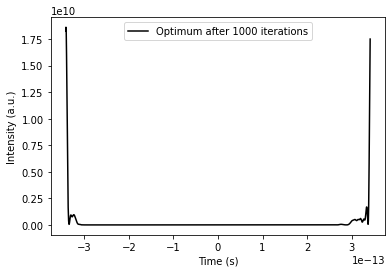

In [43]:
# Now Fourier transform
Et = np.fft.ifft(Eom_complex)

dom = om[2] - om[1]
df = dom/(2*np.pi)
t = np.fft.fftshift(np.fft.fftfreq(len(Et), d=df))
f2, axst = plt.subplots()
axst.plot(t, np.abs(Et)**2, color='black', label='Optimum after 1000 iterations')
axst.set_xlabel('Time (s)')
axst.set_ylabel('Intensity (a.u.)')
plt.legend()
plt.show()